## Download the data
(https://www.kaggle.com/lunarwhite/anime-face-dataset-ntumlds) 

Đây là bộ dữ liệu bao gồm 36,7k khuôn mặt anime chất lượng cao.

In [ ]:
! pip install -q kaggle;

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nlbinh","key":"92d9052d40baa9fa10d994ca32c4d9f0"}'}

In [ ]:
#  ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           3635        118  1.0              
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25          20126        553  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           2621         66  1.0              
fuarresvij/gdp-growth-around-the-globe                      

In [ ]:
#import necessary libraries
import torch, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import kaggle

%matplotlib inline
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
#TODO: define your own dataset address"

def download_data():
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('lunarwhite/anime-face-dataset-ntumlds', path='./', unzip=True)

download_data()

root = './faces/images/'

## Trực quan hóa ảnh đầu vào là kiểu ảnh RGB (3 màu).

In [ ]:

from PIL import Image
import glob
image_list = []
rows = []
for filename in glob.glob('./images/*.jpg'):
    im=Image.open(filename)
    rows.append([filename])
    image_list.append(filename)

print(len(image_list))

36740


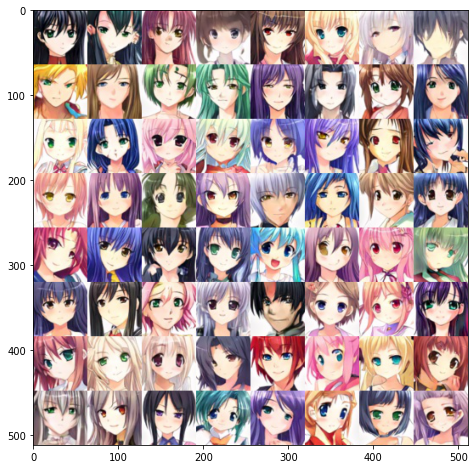

In [ ]:

def gallery(array, ncols=8):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

from PIL import Image
import random
def make_array():

    arr = []
    # Randomly select 64 images to visualize
    for i in range(64):
        random_image = random.choice(image_list)
        arr.append(np.asarray(Image.open(random_image).convert('RGB')))
    return np.array(arr)

array = make_array()
result = gallery(array)
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.show()

## Tiền xử lý dữ liệu




In [ ]:
df = pd.DataFrame(rows)
df.to_csv('data.csv', index=False, header = None)

In [ ]:
#The batch_size is defined by yourself based on the memory of GPU or CPU.
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
transform = transforms.Compose([
                                transforms.CenterCrop(64),
                                transforms.Resize(64, interpolation=2),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

class AnimeData(Dataset):
    """
    Wrap the data into a Dataset class, and then pass it to the DataLoader
    :__init__: Initialization data
    :__getitem__: support the indexing such that dataset[i] can be used to get ith sample
    :__len__: return the size of the dataset.
    """
    def __init__(self, root, transform=None):
        self.frame = pd.read_csv(root, header=None)
        self.transform = transform
        
        
    def __len__(self):
        return len(self.frame)
    
    
    def __getitem__(self, index):
        image_name = self.frame.iloc[index, 0]
        image = Image.open(image_name)
        image = self.transform(image)
        return image
#TODO: Complete the trainloader 
trainset = AnimeData(root='./data.csv', transform=transform)
trainloader = DataLoader(trainset, batch_size, shuffle=True, num_workers=0)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


## Kiểm tra thiết bị và di chuyển data sang device

`torch.cuda.is_available` kiểm tra GPU có khả dụng hay không

In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

## GAN
Một GAN bao gồm hai mạng đối thủ(adversarial network), một bộ discriminator và một bộ generator.
### Discriminator
Trong phương thức __init__, lớp Discriminator nhận vào tham số inchannels là chiều sâu của lớp convolutional đầu tiên trong mạng. Phương thức này tiếp đến tạo một container dạng sequential được gọi là conv_block1 gồm các lớp sau:

-nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1): Lớp này thực hiện một phép tích chập 2D với 64 bộ lọc có kích thước 4x4, stride là 2 và padding là 1. Đầu vào của lớp này là 3 vì ảnh là RGB

-nn.BatchNorm2d(64): Lớp này áp dụng normalization cho output của lớp tích chập trước đó, với 64 output channels.

-nn.LeakyReLU(0.2, inplace = True): Lớp này áp dụng hàm activation Leaky ReLU cho output của lớp normalization trước đó.

-nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1): Lớp tích chập tiếp theo với 128 bộ lọc có kích thước 4x4, stride là 2 và padding là 1.
`nn.BatchNorm2d(128)\


-nn.BatchNorm2d(128): Lớp normalization tiếp theo với 128 output channels.

-nn.LeakyReLU(0.2, inplace = True): Lớp hàm activation Leaky ReLU tiếp theo.

-nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1): Lớp tích chập tiếp theo với 256 bộ lọc có kích thước 4x4, stride là 2 và padding là 1.

-nn.BatchNorm2d(256): Lớp normalization tiếp theo với 256 output channels.

-nn.LeakyReLU(0.2, inplace = True): Lớp hàm activation Leaky ReLU tiếp theo.

-nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1): Lớp tích chập tiếp theo với 512 bộ lọc có kích thước 4x4, stride là 2 và padding là 1.

-nn.BatchNorm2d(512): Lớp normalization tiếp theo với 512 output channels.

-nn.LeakyReLU(0.2, inplace = True): Lớp hàm activation Leaky ReLU tiếp theo.

-nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0): Lớp tích chập tiếp theo với 1 bộ lọc có kích thước 4x4, stride là 2 và không padding.

-nn.Flatten(): Lớp này sẽ làm phẳng output của lớp tích chập trước đó

-nn.Sigmoid(): Lớp này sử dụng hàm activation sigmoid sẽ giới hạn giá trị output về khoảng [0,1]
Trong phương thức forward, input x được truyền qua container conv_block1 được tạo trong phương thức __init__ và output được trả
 về. Output này là "logits" của Discriminator, hoặc kết quả raw của quyết định của Discriminator về việc xem input có là ảnh thật hay không.


In [ ]:
#TODO: Create your Discriminator model
class Discriminator(nn.Module):
    def __init__(self,inchannels):
        super(Discriminator,self).__init__()
        """
        Initialize the Discriminator Module
        :param inchannels: The depth of the first convolutional layer
        """
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=2, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        x = self.conv_block1(x)
        return x
        
D=Discriminator(3).to(device)

## Generator

Xây dựng một mô hình generator bằng cách kế thừa từ lớp nn.Module của Pytorch và định nghĩa một phương thức forward để thực hiện việc chuyển tiếp (forward propagation) trong mô hình. Mô hình generator sử dụng một số lớp convolution transpose để tạo ra hình ảnh giả mạo từ một vectơ latent (tham số latent_size = 128) .

Sau khi khởi tạo mô hình, sử dụng noise (một vectơ random) để gọi phương thức forward của mô hình generator và lưu kết quả vào biến fake_images.

Cuối cùng,sử dụng hàm show_images để hiển thị hình ảnh giả mạo và hình ảnh thật được lấy từ trainloader.

Phần cuối của mã là sử dụng một vòng lặp và thư viện tqdm để duyệt qua trainloader, trainloader được giả sử là một tập dữ liệu hình ảnh thật. Trong mỗi lần duyệt, hình ảnh thật được chuyển đến thiết bị được chỉ định bởi biến "thiết bị" và được truyền qua hàm "show_images". Điều này có thể hiển thị hình ảnh thật trên màn hình, nhưng điều này không được chỉ định trong đoạn mã bạn cung cấp.


torch.Size([128, 3, 64, 64])


  0%|          | 0/288 [00:00<?, ?it/s]

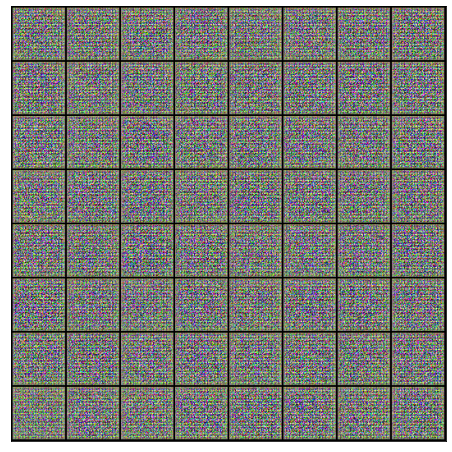

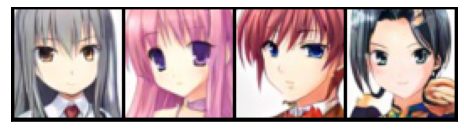

In [ ]:
# Create your Generator model
latent_size = 128
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        """
        Initialize the Generator Module
        :param latent_size: The length of the input latent vector
        """
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
            
    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 3x64x64 Tensor image as output
        """
        x = self.conv_block1(x)
        return x
        
        
G=Generator(latent_size).to(device) 
# random latent tensors
noise = torch.randn(batch_size, latent_size, 1, 1)

fake_images = G(noise)
print(fake_images.shape)

show_images(fake_images)

for real_images in tqdm(trainloader):
    real_images=(real_images).to(device)
    
show_images(real_images)

---
## Discriminator and Generator Losses.
### Discriminator Losses
d_loss = d_real_loss + d_fake_loss`. 
### Generator Loss
Sự mất mát của trình tạo sẽ trông tương tự chỉ với các nhãn được lật. Mục tiêu của bộ tạo là làm cho bộ phân biệt đối xử *nghĩ* hình ảnh được tạo của nó là *thật*.



In [ ]:
loss_fn = torch.nn.MSELoss()
def Real_loss(preds,targets):
    '''
       Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss
    '''
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds-label_noise)
    return loss
def Fake_loss(preds,targets):
    '''
       Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss
    '''
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds+label_noise)
    return loss

## Optimizers
Xác định trình tối ưu hóa cho các mô hình của bạn với các siêu tham số thích hợp.

In [ ]:
# Create optimizers for the discriminator D and generator G
#Define your learning rate
lr=0.0002
opt_d = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

### Lưu hình ảnh đã tạo
Mã này có thể giúp bạn lưu hình ảnh được tạo từ Trình tạo G

In [ ]:
##Define your save path.
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, generator, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

## Đào tạo GAN để tạo khuôn mặt anime
 sử dụng các hàm `real_loss` và `fake_loss` để giúp bạn tính toán tổn thất của bộ phân biệt.

"train" được sử dụng để huấn luyện một GAN, mà bao gồm hai mạng neural: generator (G) và discriminator (D). Hàm nhận vào một số tham số bao gồm D, G, d_optimizer, g_optimizer và epochs.

Hàm bắt đầu bằng cách khởi tạo một số danh sách (losses_g, losses_d, real_scores, fake_scores) sẽ được sử dụng để lưu trữ các mất mát và điểm của generator và discriminator trong quá trình huấn luyện. Sau đó, nó vào một vòng lặp lồng nhau mà lặp qua một số epochs, và cho mỗi epoch, lặp qua tập trainloader.

Trong mỗi lần lặp, mã đầu tiên truyền hình ảnh thực qua discriminator và tính ra mất mát bằng hàm Real_loss. Nó cũng tính ra real_score bằng cách lấy trung bình của đầu ra của discriminator. Sau đó, nó tạo ra hình ảnh giả bằng generator, và truyền chúng qua discriminator cũng. Mất mát được tính bằng hàm Fake_loss, và fake_score được tính bằng cách lấy trung bình của đầu ra của discriminator.

Mã sau đó cập nhật trọng số của discriminator bằng cách tính đạo hàm và bước với d_optimizer. Sau đó, nó tạo ra một tập hình ảnh giả khác và cố gắng lừa discriminator bằng cách truyền chúng qua discriminator và cập nhật trọng số của generator với g_optimizer.

Sau mỗi epoch, mã thêm mất mát và điểm vào danh sách tương ứng, in ra các giá trị cho epoch hiện tại, và lưu hình ảnh được tạo ra bằng hàm save_samples. Nó cũng lưu trạng thái mô hình của cả generator và discriminator sau mỗi epoch.

Tổng quan, mã này là một ví dụ cụ thể về cách huấn luyện một GAN sử dụng tập trainloader và cách cập nhật trọng số của generator và discriminator sử dụng các optimizers. Nó cũng lưu trạng thái mô hình sau mỗi epoch, lưu hình ảnh được tạo ra và ghi lại mất mát và điểm của generator và discriminator trong quá trình huấn luyện.


In [ ]:
# Complete the training function
losses_g = []
losses_d = []
real_scores = []
fake_scores = []
def train(D, G, d_optimizer, g_optimizer, epochs=1):
    iter_count = 0
    start_idx=1
    for epoch in range(epochs):
        for real_images in tqdm(trainloader):
            real_images=real_images.to(device)
            # Pass real images through discriminator
            D_out_real = D(real_images)  
            label_real = torch.full(D_out_real.shape, 1.0).to(torch.device(device))
            real_loss = Real_loss(label_real,D_out_real)
            real_score = torch.mean(D_out_real).item()
            
            # Generate fake images
            noise = torch.randn(batch_size, latent_size, 1, 1).to(torch.device(device))
            fake_images =  G(noise)
            
            # Pass fake images through discriminator
            D_out_fake = D(fake_images)
            label_fake =  torch.full(D_out_fake.shape, 0).to(torch.device(device))
            fake_loss = Fake_loss(label_fake, D_out_fake) 
            fake_score = torch.mean(D_out_fake).item()
            
            # Update discriminator weights
            loss_d = real_loss + fake_loss
            
            d_optimizer.zero_grad()
            loss_d.backward(retain_graph = True)
            d_optimizer.step()
            
            # Generate fake images
            noise2 = torch.randn(batch_size, latent_size, 1, 1).to(torch.device(device))
            fake_images2 =  G(noise2)
            
            gen_steps = 1
            for i in range(0, gen_steps ):
            # Try to fool the discriminator
                D_out_fake2 = D(fake_images2)
           
                # The label is set to 1(real-like) to fool the discriminator
                label_real1 = torch.full(D_out_fake2.shape, 1.0).to(torch.device(device))
                loss_g = Real_loss(label_real1, D_out_fake2)
            
                # Update generator weights
                g_optimizer.zero_grad()
                loss_g.backward(retain_graph = (i<gen_steps -1 ))
                g_optimizer.step()
            
            
        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent,G, show=True)
            
        state_dis = {'dis_model': D.state_dict(), 'epoch': epoch}
        state_gen = {'gen_model': G.state_dict(), 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint') 
        torch.save(state_dis, 'checkpoint/'+'D__'+str(epoch+1)) #each epoch
        torch.save(state_gen, 'checkpoint/'+'G__'+str(epoch+1)) #each epoch
#Train the GAN
train(D,G,opt_d,opt_g,epochs=15)

Output hidden; open in https://colab.research.google.com to view.

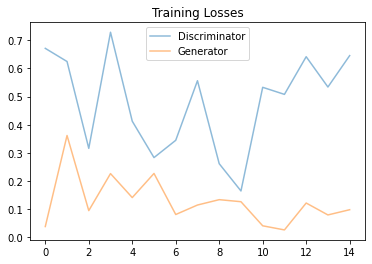

In [ ]:
##Visualize your loss curve of D and G
fig, ax = plt.subplots()
plt.plot(losses_g, label='Discriminator', alpha=0.5)
plt.plot(losses_d, label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()